In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [4]:
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU'), 'GPU')

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [52]:
ages = np.load('eICU_age.npy')
ages = ages['age'].astype(float).reshape(-1,1)
ages.shape

(2520, 1)

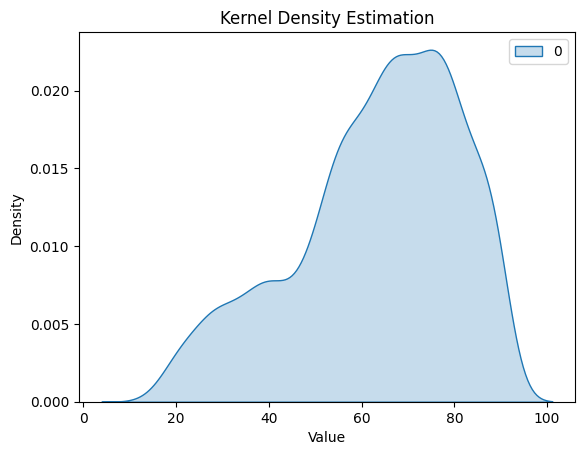

In [53]:
sns.kdeplot(ages, fill=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimation')
plt.show()

In [54]:
tf.keras.utils.disable_interactive_logging()

Epoch 0/15, Discriminator Loss: 0.6890, Generator Loss: 0.7145
Epoch 10/15, Discriminator Loss: 0.6668, Generator Loss: 0.4900


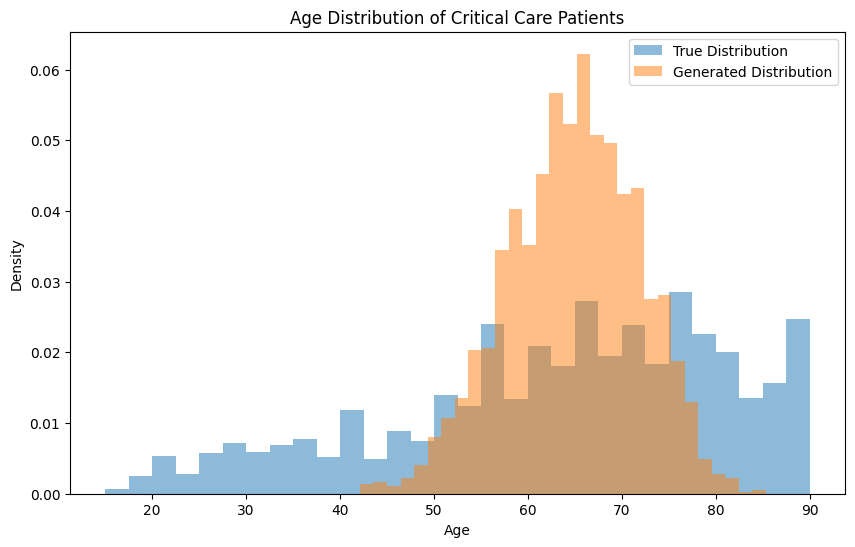

In [59]:

# Normalize the data
ages_min, ages_max = np.min(ages), np.max(ages)
normalized_ages = (ages - ages_min) / (ages_max - ages_min)

# Define the generator model
generator = Sequential()
generator.add(Dense(64, input_dim=100, activation='relu'))
generator.add(Dense(128, activation='relu'))
generator.add(Dense(1, activation='sigmoid'))

# Define the discriminator model
discriminator = Sequential()
discriminator.add(Dense(64, input_dim=1, activation='relu'))
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the models
generator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=binary_crossentropy)
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=binary_crossentropy)

# Train the GAN
batch_size = 512
epochs = 15
losses = []

for epoch in range(epochs):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, size=(batch_size, 100))

    # Generate fake samples
    generated_ages = generator.predict(noise)

    # Combine real and fake samples
    X = np.concatenate((normalized_ages, generated_ages), axis=0)
    y_real = np.concatenate((np.ones(len(normalized_ages)), np.zeros(len(generated_ages))), axis=0)

    # Train the discriminator on the combined dataset
    discriminator_loss = discriminator.train_on_batch(X, y_real)

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, size=(batch_size, 100))
    y_fake = np.ones(batch_size)
    generator_loss = generator.train_on_batch(noise, y_fake)
    # print(noise.shape, y_fake.shape, X.shape, y_real.shape)
    # break
    # Store the losses
    losses.append((discriminator_loss, generator_loss))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Discriminator Loss: {discriminator_loss:.4f}, Generator Loss: {generator_loss:.4f}')

# Generate new samples from the trained generator
noise = np.random.normal(0, 1, size=(len(ages), 100))
generated_ages = generator.predict(noise)

# Denormalize the real and generated ages
real_ages_denormalized = ages
generated_ages_denormalized = generated_ages * (ages_max - ages_min) + ages_min

# Visualize the true and generated distributions
plt.figure(figsize=(10, 6))
plt.hist(real_ages_denormalized, bins=30, density=True, alpha=0.5, label='True Distribution')
plt.hist(generated_ages_denormalized, bins=30, density=True, alpha=0.5, label='Generated Distribution')
plt.title('Age Distribution of Critical Care Patients')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()